In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve, auc,roc_curve,roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')



In [3]:
df = pd.read_csv('Taz_Water.csv')

In [4]:
df['funder'].fillna(value='Unknown',inplace=True)
df['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True)

In [5]:
df['installer'].fillna(value='Unknown',inplace=True)  # filling null values with unknown
df['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True) # filling 0 values with unknown

In [6]:
# From the most common 100 value counts we realized some spelling mistakes or different syntax between same categories

# Replacing the spelling mistakes and collect same categories in same name

df['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'),
                        value ='District water department' , inplace=True)

df['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)
df['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)

df['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 
                                      'District Council','Council','Counc','District  Council','Distri'),
                                    value ='District council' , inplace=True)

df['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 
                                      'RC CATHORIC',) , value ='RC Church' , inplace=True)

df['installer'].replace(to_replace = ('Central Government','Tanzania Government',
                                       'central government','Cental Government', 'Cebtral Government', 
                                      'Tanzanian Government','Tanzania government', 'Centra Government' ,
                                      'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 
                                      'Centra govt') , value ='Central government' , inplace=True)

df['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                        value ='world vision' , inplace=True)

df['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
df['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)

df['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 
                                      'Village Council','Village Counil', 'Villages', 'Vill', 'Village community', 
                                      'Villaers', 'Village Community', 'Villag','Villege Council', 'Village council',
                                      'Village  Council','Villagerd', 'Villager', 'Village Technician',
                                      'Village Office','Village community members'),
                                        value ='villagers' , inplace=True)

df['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY') ,
                                        value ='Community' , inplace=True)

df['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove',
                                      'Governme','Governmen' ) ,value ='Government' , inplace=True)

df['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)

In [7]:
# continue to replacing spellin mistakes and getting together values
df['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)
df['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)
df['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)
df['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)
df['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)
df['installer'].replace(to_replace = ('Village Government') , value ='Village government' , inplace=True)
df['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)
df['installer'].replace(to_replace = ('Cetral government /RC') , value ='RC church/Central Gover' , inplace=True)
df['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)
df['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)

# Unnessary Columns for preditive model

In [8]:
pred_uncol = ['date_recorded','longitude','latitude','wpt_name','num_private','subvillage'
              ,'recorded_by','scheme_name','ward','public_meeting',
             'extraction_type','payment','quality_group','source_type','quantity',
             'waterpoint_type_group','permit']

In [9]:
pred_df = df.drop(pred_uncol,axis=1)
pred_df.head()

,id,amount_tsh,funder,gps_height,installer,basin,region,region_code,district_code,lga,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity_group,source,source_class,waterpoint_type,status_group
0,69572,6000.0,Roman,1390,Roman,Lake Nyasa,Iringa,11,5,Ludewa,...,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,Grumeti,1399,GRUMETI,Lake Victoria,Mara,20,2,Serengeti,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,Lottery Club,686,world vision,Pangani,Manyara,21,4,Simanjiro,...,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,Unicef,263,Unicef,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0.0,Action In A,0,Artisan,Lake Victoria,Kagera,18,1,Karagwe,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


# Setting target to binary

In [10]:
pred_df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [11]:
pred_df['status_group'] = pred_df['status_group'].replace('functional needs repair','functional')

In [12]:
pred_df['status_group'].value_counts()

functional        36576
non functional    22824
Name: status_group, dtype: int64

In [13]:
dd = pred_df.drop('id',axis=1)
dd.isna().sum()

amount_tsh                  0
funder                      0
gps_height                  0
installer                   0
basin                       0
region                      0
region_code                 0
district_code               0
lga                         0
population                  0
scheme_management        3877
construction_year           0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source                      0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

# Train test split

In [14]:
X = dd.drop('status_group',axis=1)
y = dd['status_group']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)

# fixing the missing data

In [16]:
X_train["scheme_management"].fillna("VWC", inplace = True)
X_train['construction_year'] = X_train['construction_year'].replace(0,np.nan)
X_train['construction_year'] = X_train['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

# Test

In [17]:
X_test["scheme_management"].fillna("VWC", inplace = True)
X_test['construction_year'] = X_test['construction_year'].replace(0,np.nan)
X_test['construction_year'] = X_test['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

# Pipe lines

In [18]:
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes(['int','float']).columns


numeric_pipe = Pipeline([('numnorm',StandardScaler())])

nominal_pipe = Pipeline([
    ('onehotenc', OneHotEncoder(sparse=False,handle_unknown = 'ignore')),
    ('onehotnorm', StandardScaler())
])

In [19]:
ct = ColumnTransformer([
    ('numpipe',numeric_pipe, num_cols),
    ('nominalpipe',nominal_pipe,cat_cols),
])
ct

ColumnTransformer(transformers=[('numpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  StandardScaler())]),
                                 Index(['funder', 'installer', 'basin', 'region', 'lga', 'scheme_management',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity_group',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object'))])

In [20]:
log = Pipeline([
    ('preprocess', ct),
    ("smote", SMOTE(random_state=42)),
    ('model',LogisticRegression(random_state=42))
])
log

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   Stand...er())]),
                                                  Index(['funder', 'installer', 'basin', 'region', 'lga', 'scheme_management',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity_group',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(random_state=42))])

# Fit the Model

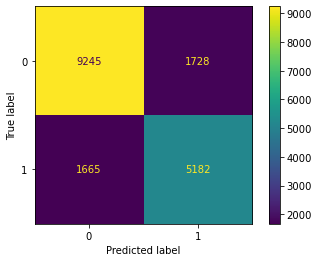

In [21]:
log.fit(X_train,y_train)
y_pred = log.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

In [22]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

    functional       0.85      0.84      0.84     10973
non functional       0.75      0.76      0.75      6847

      accuracy                           0.81     17820
     macro avg       0.80      0.80      0.80     17820
  weighted avg       0.81      0.81      0.81     17820



# Checking is overfitting

In [23]:
print(log.score(X_train,y_train))
print(log.score(X_test,y_test))

0.8278499278499278
0.8095959595959596


# AUC

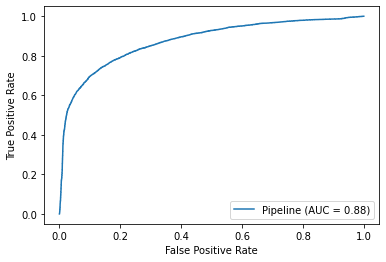

In [24]:
plot_roc_curve(log,X_test,y_test);

In [25]:
y_score = log.fit(X_train, y_train).predict_proba(X_test)
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score[:, 1])

micro_roc_auc_ovr

0.8751547257457665

# Random Search

In [26]:
from sklearn.model_selection import RandomizedSearchCV
pipe_grid = dict()
pipe_grid['model__solver'] = ['lbfgs', 'liblinear']
pipe_grid['model__penalty'] = ['l1', 'l2']
pipe_grid['model__C'] = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

In [27]:
pipe_grid

{'model__solver': ['lbfgs', 'liblinear'],
 'model__penalty': ['l1', 'l2'],
 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [28]:
gs_pipe = RandomizedSearchCV(estimator=log,
                      param_distributions=pipe_grid, n_iter=16)
gs_pipe

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('numpipe',
                                                                               Pipeline(steps=[('numnorm',
                                                                                                StandardScaler())]),
                                                                               Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                                              ('nominalpipe',
                                                                               Pipeline(steps=[('onehotenc',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              spars...
       'management_group', 'payment_type', 'water_quality', 'quantity_group',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object'))])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=16,
                   param_distributions={'model__C': [0.0001, 0.001, 0.01, 0.1,
                                                     1, 10, 100, 1000],
                                        'model__penalty': ['l1', 'l2'],
                                        'model__solver': ['lbfgs',
                                                          'liblinear']})

In [29]:
# gs_pipe.fit(X_train,y_train)

In [38]:
# gs_pipe.best_params_

In [ ]:
# gs_pipe.best_score_

In [ ]:
# from joblib import dump, load
# dump(gs_pipe.best_params_, 'log_best_params.joblib') 

In [31]:
from joblib import dump, load
clf = load('log_best_params.joblib')
clf

{'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 0.01}

# Best Model

In [32]:
best_model = Pipeline([
    ('preprocess', ct),
    ("smote", SMOTE(random_state=42)),
    ('model',LogisticRegression(random_state=42, solver = 'liblinear', penalty = 'l1', C = 0.01))
])
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   Stand...
                                                  Index(['funder', 'installer', 'basin', 'region', 'lga', 'scheme_management',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity_group',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=0.01, penalty='l1', random_state=42,
                                    solver='liblinear'))])

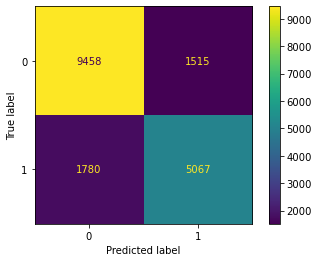

In [33]:
best_model.fit(X_train,y_train)
best_y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

# Best Model Accuracy

In [34]:
print(best_model.score(X_test,y_test))

0.8150953984287318


In [35]:
print(classification_report(y_test, best_y_pred))

                precision    recall  f1-score   support

    functional       0.84      0.86      0.85     10973
non functional       0.77      0.74      0.75      6847

      accuracy                           0.82     17820
     macro avg       0.81      0.80      0.80     17820
  weighted avg       0.81      0.82      0.81     17820



# Best Model AUC

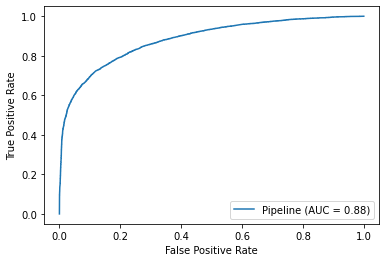

In [37]:
plot_roc_curve(best_model,X_test,y_test);